## Данные
В данных содержатся записи для 17 человек на протяжении около 11 минут.
ЭЭГ собирался с 64 датчиков с частотой дискретизаци в 1000 Hz, которая понизилась до 250 после очистки от шумов.
фМРТ TR/TE 2160/30 ms. 30 срезов размера 64x64, обновление вольюма происходит каждые 2160 ms. При этом вольюм формируется срез за срезом, расстояние во времени между соседними 72 ms. Всего вольюмов на человека 300.

Таким образом, получается 300 уникальных значений для каждого вокселя. Чтобы увеличить количество примеров в обучении, фМРТ интреполируется как взвешенное (по времени) среднее между соседними (по времени) срезами для фиксированного вокселя. В этом эксперименте семплирование происходит каждые 80ms. 

Для обучения использовались первые 210 вольюмов, для тестирования — последние 60. Таким образом, между обучением и тестом есть временной зазор и данные с этих этапов не смешиваются.



## Обучение

Обучение происходит на паре ЭЭГ — фМРТ. ЭЭГ срез берётся по 16 секундам до появления соответсвующего фМРТ значения. ЭЭГ предобрабатывается с помощью stft. Полученных таким образом признаков все еще слишком много, поэтому их размерность понижается с помощью PCA. Итоговое количество признаков перебиралось. На данный момент обучилось для 200, 300 400 и 500 признаков 

Так как линейные модели обучаются для каждого вокселя независимо, можно выкинуть часть вокселей из обучения для ускорения. Получившиеся воксели на картинках ниже. 

In [1]:
import os
import pickle
import multiprocessing
import itertools
from tqdm import tqdm_notebook

from skimage import io
from matplotlib import pyplot as plt
from skimage.morphology import erosion, square
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet

from IPython.display import clear_output
from dataHandlers.datasetCreator import Sampler
from dataHandlers import settings
from visualisation.utils import concatenate_collage



In [2]:
sampler = Sampler('../data', segment_length=1024*4)
clear_output()

In [3]:
num_frames = 300
num_train_frames = 210
num_val_frames = 30
num_test_frames = 60
train_start = 0
train_end = settings.frame_creation_time * num_train_frames
test_start = settings.frame_creation_time * (num_frames - num_test_frames)
test_end = settings.frame_creation_time * num_frames

patient_list = sampler.patient_list
random_state = 42

save_path = '../experiments/linear/elastic_2'
models_path = os.path.join(save_path, 'models')
pcas_path = os.path.join(save_path, 'pcas')

if not os.path.isdir(save_path):
    os.makedirs(save_path)
if not os.path.isdir(models_path):
    os.makedirs(models_path)
if not os.path.isdir(pcas_path):
    os.makedirs(pcas_path)

In [4]:
def get_fmri_slice_mask(mean_fmri_slice):
    non_empty_voxels = mean_fmri_slice > 66
    voxels_num = non_empty_voxels.sum()
    selem_size = int(np.sqrt(voxels_num) / 4.5)
    entire_voxels = erosion(mean_fmri_slice > 66, selem=square(selem_size))
    result_mask = non_empty_voxels * ~entire_voxels
    return result_mask

def get_fmri_mask(fmri):
    mean_fmri = fmri.mean(-1)
    fmri_mask = np.concatenate([get_fmri_slice_mask(mean_fmri[..., i])[..., None] for i in range(30)], -1)
    return fmri_mask

In [5]:
current_patient = patient_list[0]
fmri = sampler.fmri_data[current_patient]
mean_fmri = fmri.mean(-1)
tresholded_mask = mean_fmri > 66
fmri_mask = get_fmri_mask(fmri)

/opt/conda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


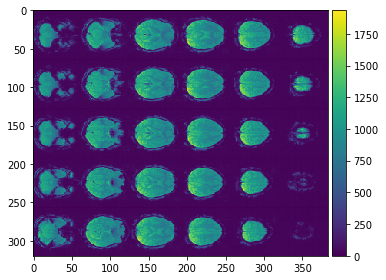

In [6]:
io.imshow(concatenate_collage(mean_fmri))

#### Первая фильтрация вокселей — трешхолд по средней активации.

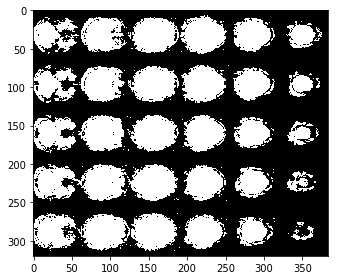

In [7]:
io.imshow(concatenate_collage(tresholded_mask))

#### Вторая фильтрация — выкидывание вокселей по середине.

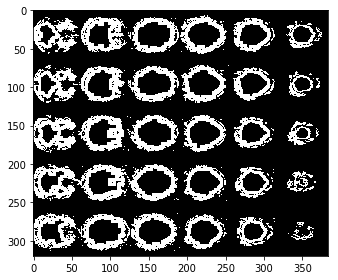

In [8]:
io.imshow(concatenate_collage(fmri_mask))

In [9]:
print("total num of voxels: {}\ntresholded num of voxels: {}\nresult num of voxels: {}".format(np.prod(fmri_mask.shape),
                                                                                              tresholded_mask.sum(),
                                                                                              fmri_mask.sum()))

total num of voxels: 122880
tresholded num of voxels: 49210
result num of voxels: 29535


In [10]:
def get_masked_y(y, fmri_mask):
    return y[np.concatenate([fmri_mask[None, ...]] * y.shape[0])].reshape(y.shape[0], -1)

#### Основной перебор запускал по количеству признаков после PCA, остальные параметры планирую перебрать после того, как пойму оптимальное количество признаков.

In [ ]:
x_train, y_train = sampler.create_one_man_dataset(current_patient, train_start, train_end)

preprocessed_train_y = get_masked_y(y_train, fmri_mask)

num_features_list = [200, 300, 400, 500, 600, 700]
alpha_list = np.linspace(1e-1, 1, 3)
l1_ratio_list = np.linspace(0, 1, 3)
normalize_list = [False, True]

In [ ]:
def fit_model(x, y, alpha, l1_ratio, normalize, num_features):
    global save_path, current_patient, random_state
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, normalize=normalize, random_state=random_state, max_iter=100)
    model.fit(x, y)
    model_name = '{}_{}_{}_{}_{}.pkl'.format(current_patient, num_features, alpha, l1_ratio, normalize)
    model_path = os.path.join(models_path, model_name)
    pickle.dump(model, open(model_path, 'wb'))

In [ ]:
def fit_pca_models(x_train, preprocessed_train_y, num_features, alpha_list, l1_ratio_list, normalize_list):
    pca = PCA(num_features, random_state=random_state)
    pca.fit(x_train)
    preprocessed_train_x = pca.transform(x_train)
    pca_name = '{}_{}.pkl'.format(current_patient, num_features)
    pca_path = os.path.join(pcas_path, pca_name)
    pickle.dump(pca, open(pca_path, 'wb'))
    for alpha, l1_ratio, normalize in tqdm_notebook(itertools.product(alpha_list, l1_ratio_list, normalize_list)):
        fit_model(preprocessed_train_x, preprocessed_train_y, alpha, l1_ratio, normalize, num_features)

In [ ]:
for num_features in num_features_list:
    fit_pca_models(x_train, preprocessed_train_y, num_features, alpha_list, l1_ratio_list, normalize_list)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
